In [8]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from alphatoe.interpretability import numpy
from alphatoe import plot, game, evals, interpretability
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = interpretability.load_model(
    "../scripts/models/prob all 8 layer control with checkpoints-20250708-002411-epoch600"
)

model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control with checkpoints-20250708-002411"
)


In [3]:
seq_fwd = torch.tensor([[10, 0, 1, 2, 3, 4, 5, 7, 8, 6]])
pos_emb = model.pos_embed(seq_fwd, 0)[0] #positional embedding (10, 128)
#normalize all positional embeddings
pos_emb_normed = pos_emb/torch.norm(pos_emb, dim=-1, keepdim=True)
W_pos = model.W_pos #(10, 128)
W_K = model.W_K[0, 1] # Head index 1 (128, 16)
W_Q = model.W_Q[0, 1] # Head index 1 (128, 16)
print(type(W_Q))
K = pos_emb@W_K #(10, 16)
Q = pos_emb@W_Q #(10, 16)
vmin = -.25
vmax = .25

dotty = Q@K.T
dotty = dotty/torch.sqrt(torch.tensor(16))

<class 'torch.Tensor'>


In [4]:
seq_fwd = torch.tensor([[10, 0, 1, 2, 3, 4, 5, 7, 8, 6]])
pos_emb_live = data.pos_embed(seq_fwd, 0)[0] #positional embedding (10, 128)
W_K_live = data.W_K[0, 1] # Head index 1 (128, 16)
W_Q_live = data.W_Q[0, 1] # Head index 1 (128, 16)
print(type(W_Q_live))
K_live = pos_emb_live@W_K_live #(10, 16)
Q_live = pos_emb_live@W_Q_live #(10, 16)
vmin = -.25
vmax = .25

dotty_live = Q_live@K_live.T
dotty_live = dotty_live/torch.sqrt(torch.tensor(16))

<class 'torch.Tensor'>


In [5]:
similarity = np.linalg.norm(numpy(W_Q) - numpy(W_Q_live), 'fro') / np.linalg.norm(numpy(W_Q), 'fro')
print(similarity)

0.19587912


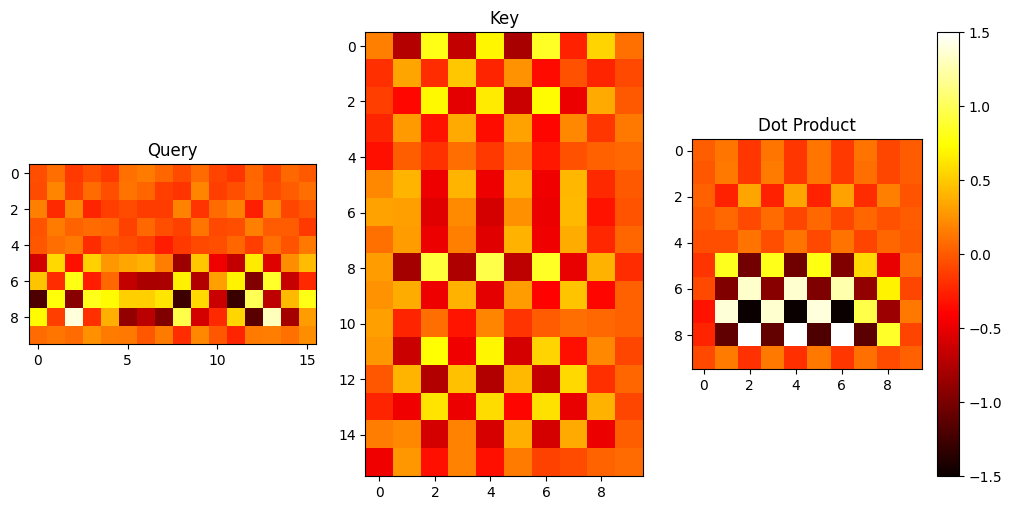

In [6]:
fig, axes = plt.subplots(1,3, figsize=(10,5))
im1 = axes[1].imshow(numpy(K_live.T), cmap='hot', vmin=-1.5, vmax=1.5)
axes[1].set_title('Key')
im0 = axes[0].imshow(numpy(Q_live), cmap='hot', vmin=-1.5, vmax=1.5)
axes[0].set_title('Query')
im2 = axes[2].imshow(numpy(dotty_live), cmap='hot', vmin=-1.5, vmax=1.5)
axes[2].set_title('Dot Product')
plt.tight_layout()
#colorbar
fig.colorbar(im2, ax=axes[2])
plt.show()

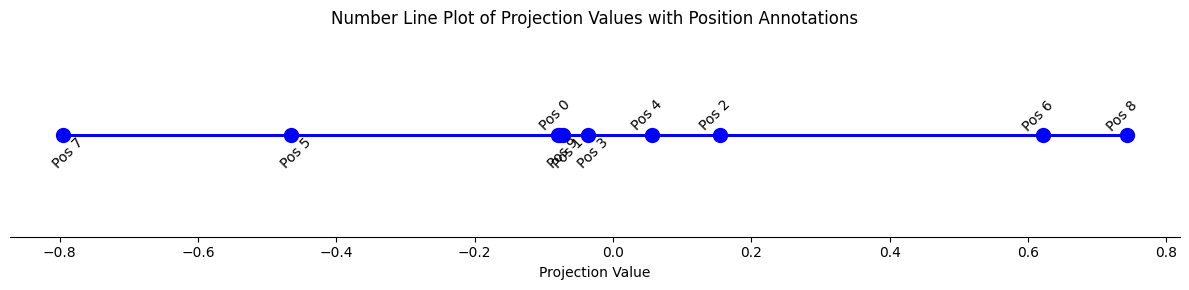

In [7]:
U, S, V = np.linalg.svd(numpy(W_Q_live))
#projection of posemd onto U of W_Q
Q_proj = numpy(pos_emb_live) @ U[:,:1]
#turn to list
Q_proj = Q_proj.tolist()
#list of just numbers rather than list of lists
Q_proj = [x[0] for x in Q_proj]
#zip with range 0-9
Q_proj = list(zip(range(10), Q_proj))

# Unzip the list of tuples
positions, values = zip(*Q_proj)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 3))

# Plot the number line
ax.plot(values, [0]*len(values), 'b-', linewidth=2)

# Plot the points
ax.plot(values, [0]*len(values), 'bo', markersize=10)

# Add annotations, alternating above and below
for i, (pos, val) in enumerate(Q_proj):
    if i % 2 == 0:
        y_pos = 10
        va = 'bottom'
    else:
        y_pos = -10
        va = 'top'
    
    ax.annotate(f'Pos {pos}', (val, 0), xytext=(0, y_pos), 
                textcoords='offset points', ha='center', va=va,
                rotation=45, rotation_mode='anchor')

# Remove y-axis and spines
ax.yaxis.set_visible(False)
for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

# Set x-axis label and title
ax.set_xlabel('Projection Value')
ax.set_title('Number Line Plot of Projection Values with Position Annotations')

# Adjust layout and display
plt.tight_layout()
plt.show()
